##### This Project is all about the generation of synthetic datasets in variational autoencoders and the crop dataset what will be used as experiment here

In [97]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

##### Load the dataset, Keep the necessary columns and drop the unnecessary one

In [2]:
df = pd.read_csv('crop modified.csv')
df.head(5)

,Unnamed: 0,N,P,K,temperature,humidity,ph,rainfall,label
0,0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,4,78,42,42,20.130175,81.604873,7.628473,262.717340,20


In [98]:
df2 = df.drop(['label', 'Unnamed: 0'], axis='columns')
df2

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340
...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507
2196,99,15,27,27.417112,56.636362,6.086922,127.924610
2197,118,33,30,24.131797,67.225123,6.362608,173.322839
2198,117,32,34,26.272418,52.127394,6.758793,127.175293


##### Building the AutoEncoder Architecture

In [99]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

##### For this part of the autoencoder, the z_mean and z_log_var values(They are the latent space values) will be changed using different values, for experiments

##### We will be keeping the architecture structure constant throughout the course of the experiment, only the latent space values will change

In [166]:
encoder_input = Input(shape=(7,))
x = Dense(10, activation='relu')(encoder_input)
x = Dense(5, activation='relu')(x)
z_mean = Dense(100)(x) # changing value
z_log_var = Dense(100)(x) # changing value
z = Sampling()([z_mean, z_log_var])
encoder = keras.models.Model(inputs=[encoder_input], outputs=[z_mean, z_log_var, z],name="encoder")


##### The value of the Decoder input will also change here alongside the z_mean and z_log_var values

In [167]:
decoder_input = Input(shape=100,) # changing value
x = Dense(5, activation='relu')(decoder_input)
x = Dense(10, activation='relu')(x)
decoder_output = Dense(7)(x)
decoder = keras.models.Model(inputs=[decoder_input], outputs=[decoder_output])

In [168]:
_, _, codings = encoder(encoder_input)
reconstructions = decoder(codings)
variational_ae = tf.keras.Model(inputs=[encoder_input], outputs=[reconstructions])

In [169]:
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss)/7)

In [170]:
variational_ae.compile(loss='mse', optimizer='nadam')

In [171]:
variational_ae.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 7)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 100),                1335      ['input_18[0][0]']            
                              (None, 100),                                                        
                              (None, 100)]                                                        
                                                                                                  
 model_17 (Functional)       (None, 7)                    642       ['encoder[0][2]']             
                                                                                           

##### Data Preprocessing and Data Preparation

In [172]:
data = df.drop('Unnamed: 0', axis='columns')
data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,5


In [173]:
x = data.drop('label', axis='columns')

In [174]:
y = data['label']

In [175]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [176]:
x_train.shape

(1760, 7)

In [177]:
x_test.shape

(440, 7)

In [178]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

## EXPERIMENTS
##### Data Generated when the Latent Space Value = 2

In [116]:
history = variational_ae.fit(x_train_scaled, x_train_scaled, epochs=100, verbose=False, validation_data=(x_test_scaled, x_test_scaled))

In [117]:
codings_synthetic = tf.random.normal(shape=[300 * 7, 2])
synthetic_data = decoder(codings_synthetic).numpy()

In [120]:
synthetic_dataframe = pd.DataFrame(synthetic_data, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
synthetic_dataframe

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,0.358427,0.335956,0.215304,0.471889,0.663605,0.462576,0.293760
1,0.364768,0.338722,0.200933,0.473707,0.664102,0.480937,0.301108
2,0.369637,0.347568,0.214681,0.483246,0.659705,0.471924,0.291582
3,0.358844,0.339947,0.215349,0.475294,0.667633,0.460938,0.296249
4,0.367698,0.345227,0.210393,0.476201,0.664940,0.470970,0.293331
...,...,...,...,...,...,...,...
2095,0.367336,0.344999,0.210470,0.476126,0.665157,0.470684,0.293563
2096,0.358914,0.340889,0.215211,0.475980,0.668305,0.460297,0.296677
2097,0.359496,0.341521,0.215608,0.476596,0.668507,0.460727,0.296542
2098,0.360432,0.334566,0.205199,0.466473,0.661693,0.469020,0.294809


In [121]:
#GENERATED DATA, Reverse the Generated to the initial form using the inverse_transform function
inverse_dataset = scaler.inverse_transform(synthetic_dataframe)
id_2 = pd.DataFrame(inverse_dataset, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
id_2 # 2 here is the latent space value

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,50.179760,52.033783,49.630280,25.716028,70.973671,6.363962,101.204788
1,51.067535,52.421051,46.784809,25.776772,71.016121,6.477226,103.230774
2,51.749233,53.659496,49.506756,26.095453,70.640381,6.421626,100.604523
3,50.238129,52.592545,49.639179,25.829788,71.317963,6.353856,101.891113
4,51.477669,53.331810,48.657829,25.860075,71.087791,6.415738,101.086548
...,...,...,...,...,...,...,...
2095,51.427090,53.299858,48.673138,25.857574,71.106331,6.413975,101.150711
2096,50.248013,52.724472,49.611778,25.852688,71.375343,6.349902,102.009048
2097,50.329468,52.812889,49.690357,25.873293,71.392609,6.352556,101.971870
2098,50.460442,51.839226,47.629475,25.535078,70.810242,6.403709,101.493988


##### Data Generated when the Latent Space Value = 20

In [135]:
history = variational_ae.fit(x_train_scaled, x_train_scaled, epochs=100, verbose=False, validation_data=(x_test_scaled, x_test_scaled))

In [143]:
codings_synthetic = tf.random.normal(shape=[300 * 7, 20])
synthetic_data_20 = decoder(codings_synthetic).numpy()

In [145]:
synthetic_dataframe_20 = pd.DataFrame(synthetic_data_20, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
synthetic_dataframe_20

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,0.359158,0.350146,0.211423,0.483296,0.655238,0.459049,0.286864
1,0.343494,0.336097,0.217400,0.495648,0.669377,0.473060,0.281729
2,0.352254,0.347730,0.216065,0.491585,0.666527,0.470153,0.286645
3,0.348895,0.358017,0.218988,0.476425,0.642891,0.455998,0.275290
4,0.358223,0.350864,0.212113,0.482669,0.654112,0.458771,0.285809
...,...,...,...,...,...,...,...
2095,0.343320,0.336104,0.217361,0.495954,0.669468,0.473368,0.281236
2096,0.353824,0.338011,0.207746,0.485043,0.653319,0.454164,0.280792
2097,0.356476,0.354590,0.220824,0.484771,0.643928,0.454881,0.290285
2098,0.361053,0.349877,0.215078,0.487552,0.653128,0.458072,0.293848


In [146]:
#GENERATED DATA, Reverse the Generated to the initial form using the inverse_transform function
inverse_dataset_20 = scaler.inverse_transform(synthetic_dataframe_20)
id_20 = pd.DataFrame(inverse_dataset, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
id_20 # 20 here is the latent space value

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,49.772133,54.411640,49.393509,26.015640,69.883995,6.335520,98.170792
1,50.518867,54.494446,51.498970,26.349293,69.077026,6.304507,103.315414
2,48.873959,55.100418,50.329716,25.872147,69.224358,6.323754,96.176132
3,50.422390,54.186901,49.920895,26.209108,69.795128,6.326990,101.071831
4,50.183483,53.962955,50.377895,26.372528,70.306824,6.359583,101.670204
...,...,...,...,...,...,...,...
2095,51.438843,53.025227,49.207905,26.101198,72.372643,6.331878,107.349564
2096,49.999542,53.989189,51.712650,26.488073,70.321701,6.360601,103.855057
2097,49.922947,54.443001,49.883148,26.087814,69.690742,6.328345,99.287682
2098,52.602406,53.354412,51.067429,26.370300,73.487953,6.370011,109.715134


##### Data Generated when the Latent Space Value = 50

In [162]:
history = variational_ae.fit(x_train_scaled, x_train_scaled, epochs=100, verbose=False, validation_data=(x_test_scaled, x_test_scaled))

In [163]:
codings_synthetic = tf.random.normal(shape=[300 * 7, 50])
synthetic_data_50 = decoder(codings_synthetic).numpy()

In [164]:
synthetic_dataframe_50 = pd.DataFrame(synthetic_data_50, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
synthetic_dataframe_50

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,0.361374,0.344425,0.214539,0.480773,0.668297,0.462313,0.295896
1,0.362334,0.344096,0.213777,0.481640,0.670209,0.463296,0.296821
2,0.361182,0.344490,0.214691,0.480600,0.667915,0.462116,0.295711
3,0.362573,0.344014,0.213587,0.481856,0.670684,0.463541,0.297051
4,0.361880,0.344251,0.214138,0.481230,0.669304,0.462831,0.296383
...,...,...,...,...,...,...,...
2095,0.362371,0.344083,0.213748,0.481674,0.670282,0.463334,0.296857
2096,0.362692,0.343973,0.213494,0.481963,0.670920,0.463662,0.297165
2097,0.362229,0.344132,0.213861,0.481545,0.669999,0.463188,0.296720
2098,0.362371,0.344083,0.213748,0.481674,0.670282,0.463334,0.296857


In [165]:
#GENERATED DATA, Reverse the Generated to the initial form using the inverse_transform function
inverse_dataset = scaler.inverse_transform(synthetic_dataframe_50)
id_50 = pd.DataFrame(inverse_dataset, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
id_50 # 50 here is the latent space value

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,50.592331,53.219437,49.478752,26.012842,71.374695,6.362336,101.793739
1,50.726799,53.173401,49.327862,26.041811,71.538078,6.368402,102.048874
2,50.565464,53.228638,49.508900,26.007053,71.342049,6.361125,101.742775
3,50.760265,53.161938,49.290302,26.049021,71.578735,6.369912,102.112366
4,50.663189,53.195179,49.399239,26.028107,71.460785,6.365532,101.928185
...,...,...,...,...,...,...,...
2095,50.731987,53.171623,49.322037,26.042929,71.544380,6.368636,102.058723
2096,50.776817,53.156273,49.271732,26.052588,71.598846,6.370658,102.143768
2097,50.712070,53.178440,49.344383,26.038639,71.520187,6.367738,102.020935
2098,50.731987,53.171623,49.322037,26.042929,71.544380,6.368636,102.058723


##### Data Generated when the Latent Space Value = 100

In [179]:
history = variational_ae.fit(x_train_scaled, x_train_scaled, epochs=100, verbose=False, validation_data=(x_test_scaled, x_test_scaled))

In [180]:
codings_synthetic = tf.random.normal(shape=[300 * 7, 100])
synthetic_data_100 = decoder(codings_synthetic).numpy()

In [181]:
synthetic_dataframe_100= pd.DataFrame(synthetic_data_100, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
synthetic_dataframe_100

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,0.357200,0.341025,0.199262,0.456087,0.656243,0.470043,0.291612
1,0.357694,0.347582,0.211409,0.467579,0.668202,0.468787,0.297906
2,0.366541,0.340945,0.204014,0.465683,0.659274,0.466969,0.287296
3,0.356735,0.342572,0.210172,0.467251,0.668174,0.470209,0.297784
4,0.364704,0.344728,0.211888,0.471482,0.667002,0.465635,0.290954
...,...,...,...,...,...,...,...
2095,0.361902,0.346173,0.213508,0.471229,0.668948,0.465867,0.293236
2096,0.353863,0.341879,0.229920,0.495646,0.665358,0.475940,0.311188
2097,0.363275,0.344082,0.212775,0.472149,0.668566,0.466855,0.293336
2098,0.363790,0.345994,0.214367,0.473111,0.669487,0.465288,0.292316


In [182]:
#GENERATED DATA, Reverse the Generated to the initial form using the inverse_transform function
inverse_dataset = scaler.inverse_transform(synthetic_dataframe)
id_100 = pd.DataFrame(inverse_dataset, columns=['sN', 'sP', 'sK', 'sTemperature', 'sHumidity', 'sPh', 'sRainfall'])
id_100 # 100 here is the latent space value

,sN,sP,sK,sTemperature,sHumidity,sPh,sRainfall
0,49.772133,54.411640,49.393509,26.015640,69.883995,6.335520,98.170792
1,50.518867,54.494446,51.498970,26.349293,69.077026,6.304507,103.315414
2,48.873959,55.100418,50.329716,25.872147,69.224358,6.323754,96.176132
3,50.422390,54.186901,49.920895,26.209108,69.795128,6.326990,101.071831
4,50.183483,53.962955,50.377895,26.372528,70.306824,6.359583,101.670204
...,...,...,...,...,...,...,...
2095,51.438843,53.025227,49.207905,26.101198,72.372643,6.331878,107.349564
2096,49.999542,53.989189,51.712650,26.488073,70.321701,6.360601,103.855057
2097,49.922947,54.443001,49.883148,26.087814,69.690742,6.328345,99.287682
2098,52.602406,53.354412,51.067429,26.370300,73.487953,6.370011,109.715134


#### Dimensionality Reduction using Vanilla AutoEncoder to Encode the experiments results into 2D latent space and compare there representations

##### Original Dataset

In [183]:
original_encoder = Sequential([Input(shape=(7,)),
    Dense(5),
    Dense(2)]
    )

original_decoder = Sequential([Dense(2),
                      Dense(5),
                      Dense(7)])

original_autoencoder = Sequential([original_encoder, original_decoder])


In [184]:
optimizer = keras.optimizers.SGD(learning_rate=0.5)
original_autoencoder.compile(loss="mse", optimizer=optimizer)

In [185]:
# Changing the fit parameters to train the autoencoder on the generated dataset, from latent space=2, 20, 50 and 100
h = original_autoencoder.fit(x_train_scaled, x_train_scaled, epochs=100, verbose=False)

In [187]:
original_encoded_data = original_encoder.predict(x_train_scaled)
original_encoded_data

55/55 [==============================] - 0s 3ms/step


array([[-0.4841376 , -0.21331154],
       [-0.33155516,  0.23527503],
       [-0.15825424,  0.4280433 ],
       ...,
       [-0.15929192,  0.14605637],
       [-0.26352647,  1.8949063 ],
       [-0.24646074,  0.32067952]], dtype=float32)

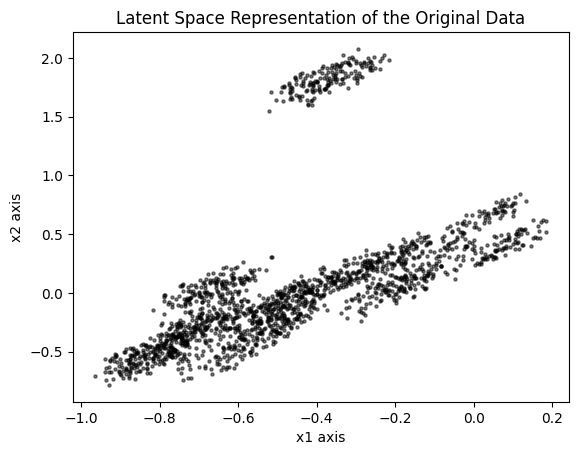

In [188]:
##### Visualizing the Latent Space
plt.title('Latent Space Representation of the Original Data')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.scatter(original_encoded_data[:, 0], original_encoded_data[:, 1], c='black', alpha=0.5, s=5)
plt.show()

##### Representation of the Generated Dataset with Latent Space = 2

In [192]:
h = original_autoencoder.fit(synthetic_data, synthetic_data, epochs=100, verbose=False)

In [193]:
original_encoded_data = original_encoder.predict(synthetic_data)
original_encoded_data

66/66 [==============================] - 0s 5ms/step


array([[-0.44641793,  0.12266234],
       [-0.4467116 ,  0.12949456],
       [-0.43565547,  0.14336126],
       ...,
       [-0.44628394,  0.12457915],
       [-0.49387252,  0.08719467],
       [-0.44918042,  0.09817296]], dtype=float32)

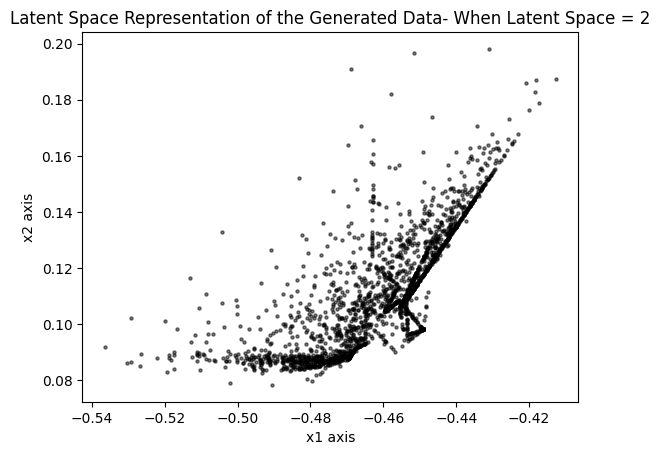

In [194]:
##### Visualizing the Latent Space
plt.title('Latent Space Representation of the Generated Data- When Latent Space = 2')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.scatter(original_encoded_data[:, 0], original_encoded_data[:, 1], c='black', alpha=0.5, s=5)
plt.show()

##### Representation of the Generated Dataset with Latent Space = 20

In [195]:
h = original_autoencoder.fit(synthetic_data_20, synthetic_data_20, epochs=100, verbose=False)

In [196]:
original_encoded_data = original_encoder.predict(synthetic_data_20)
original_encoded_data

66/66 [==============================] - 0s 4ms/step


array([[-0.45939067,  0.10325228],
       [-0.46312204,  0.10054374],
       [-0.46441016,  0.10606629],
       ...,
       [-0.4503139 ,  0.12431376],
       [-0.46062467,  0.10425432],
       [-0.45751098,  0.10978773]], dtype=float32)

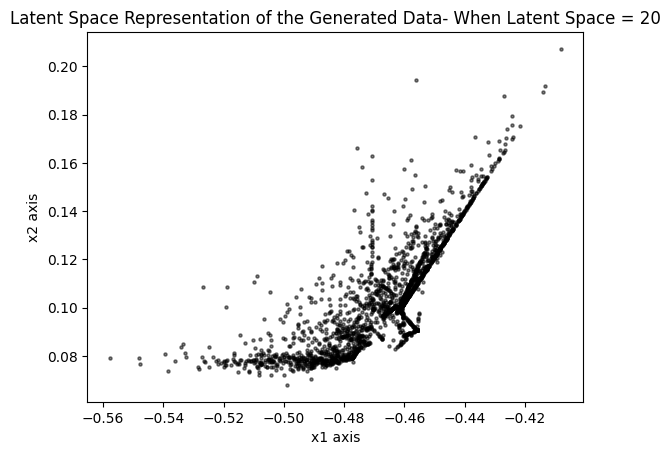

In [197]:
##### Visualizing the Latent Space
plt.title('Latent Space Representation of the Generated Data- When Latent Space = 20')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.scatter(original_encoded_data[:, 0], original_encoded_data[:, 1], c='black', alpha=0.5, s=5)
plt.show()

##### Representation of the Generated Dataset with Latent Space = 50

In [198]:
h = original_autoencoder.fit(synthetic_data_50, synthetic_data_50, epochs=100, verbose=False)

In [199]:
original_encoded_data = original_encoder.predict(synthetic_data_50)
original_encoded_data

66/66 [==============================] - 0s 3ms/step


array([[-0.4714291 ,  0.0941767 ],
       [-0.4735273 ,  0.0911459 ],
       [-0.47100985,  0.09478227],
       ...,
       [-0.47329748,  0.09147774],
       [-0.47360831,  0.09102885],
       [-0.47342616,  0.09129208]], dtype=float32)

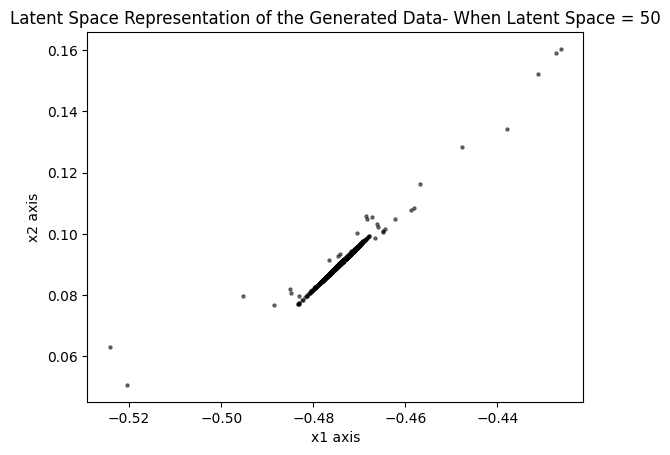

In [200]:
##### Visualizing the Latent Space
plt.title('Latent Space Representation of the Generated Data- When Latent Space = 50')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.scatter(original_encoded_data[:, 0], original_encoded_data[:, 1], c='black', alpha=0.5, s=5)
plt.show()

##### Representation of the Generated Dataset with Latent Space = 100

In [201]:
h = original_autoencoder.fit(synthetic_data_100, synthetic_data_100, epochs=100, verbose=False)

In [202]:
original_encoded_data = original_encoder.predict(synthetic_data_100)
original_encoded_data

66/66 [==============================] - 0s 4ms/step


array([[-0.45522258,  0.08191596],
       [-0.46484438,  0.09725036],
       [-0.46316907,  0.07824604],
       ...,
       [-0.46879044,  0.09026001],
       [-0.46938637,  0.09390175],
       [-0.46665308,  0.10710338]], dtype=float32)

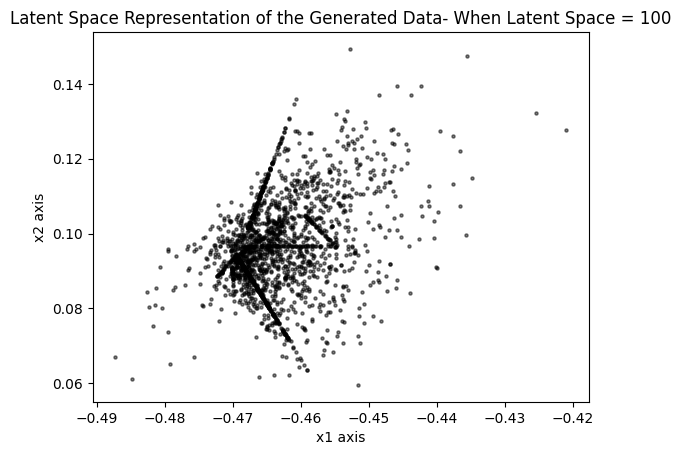

In [203]:
##### Visualizing the Latent Space
plt.title('Latent Space Representation of the Generated Data- When Latent Space = 100')
plt.xlabel('x1 axis')
plt.ylabel('x2 axis')
plt.scatter(original_encoded_data[:, 0], original_encoded_data[:, 1], c='black', alpha=0.5, s=5)
plt.show()

##### In conclusion to this particular experiment differnt latent space values were used to test the Variational AutoEncoder in synthetic data generation and all experiments were passed through a vanilla AutoEncoder, using the encoder part of the vanilla AutoEncoder to visualize the synthetic data generated. The following were observed:

#####    1. In the original dataset, Majority  has an acsending structure, something of a postive corrrelation
#####    2. In the Generated Dataset of Latent Space = 2, we see also a slightly positive correlated data
#####    3. The Data Generated when the Latent Space = 20 is also similar to when it is = 2, but a bit converged than when the Latent Space = 2
#####    4. When the Latent Value was set to 50, we could see a highly positively correlated dataset, which is not close to what we're looking for.
#####    5. At 100, the Generated data lacks clear direction.

##### P.S This is still an ongoing project, updates can come in any moment